# Analyzing the scraped data with pandas and mlflow

In [108]:
# MLflow
import mlflow
from mlflow.models import infer_signature

# MLflow model
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualizations
import matplotlib.pyplot as plt

# math functions
import numpy as np

# read CSV file
import os
import glob

# data frames
import pandas as pd

# regexes
import re

In [95]:
# https://medium.com/bitgrit-data-science-publication/sentiment-analysis-on-reddit-tech-news-with-python-cbaddb8e9bb6

# Load Libraries

import pandas as pd
import numpy as np

# misc
import datetime as dt
from pprint import pprint
from itertools import chain

# reddit crawler
import praw

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud

# Downloading NLTK's databases
nltk.download('vader_lexicon') # get lexicons data
nltk.download('punkt') # for tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load dataset in pandas

In [96]:
# future warnings
import warnings
warnings.filterwarnings("ignore")

topics_dict = { "date":[],
                "author":[],
                "title":[],
                "ups":[],
                "downs":[],
                "score":[],
                "id":[],
                "url":[],
                "comms_num": [],
                "created": [],
                "body":[]}
# Use the Reddit dataset
"""
['date','author','title','ups','downs','score','id','url','comms_num','created','body']
"""
df = pd.DataFrame()
running_total = 0
for fname in glob.glob(os.path.abspath('./data/**/*.csv')):
    _df=pd.read_csv(fname)
    _df['query'] = os.path.splitext(os.path.basename(fname))[0]
    _df['subreddit'] = os.path.basename(os.path.dirname(fname))
    df = df.append(_df.copy(), ignore_index=True)
    running_total+=len(_df)
    print(fname)
    print(running_total)
    #break #DEBUG

# setup the created datetime
df['created_date'] = pd.to_datetime(df['created'], unit='s')

c:\Users\georg\Documents\GitHub\reddit-gpt\data\artificial\chatgpt.csv
100
c:\Users\georg\Documents\GitHub\reddit-gpt\data\artificial\gpt-3.csv
400
c:\Users\georg\Documents\GitHub\reddit-gpt\data\artificial\gpt-4.csv
600
c:\Users\georg\Documents\GitHub\reddit-gpt\data\artificial\gpt.csv
1000
c:\Users\georg\Documents\GitHub\reddit-gpt\data\artificial\llm.csv
1700
c:\Users\georg\Documents\GitHub\reddit-gpt\data\artificial\open-ai.csv
2300
c:\Users\georg\Documents\GitHub\reddit-gpt\data\artificial\openai.csv
2800
c:\Users\georg\Documents\GitHub\reddit-gpt\data\chatgpt\chatgpt.csv
5679
c:\Users\georg\Documents\GitHub\reddit-gpt\data\chatgpt\gpt-3.csv
8758
c:\Users\georg\Documents\GitHub\reddit-gpt\data\chatgpt\gpt-4.csv
11737
c:\Users\georg\Documents\GitHub\reddit-gpt\data\chatgpt\gpt.csv
14916
c:\Users\georg\Documents\GitHub\reddit-gpt\data\chatgpt\llm.csv
18395
c:\Users\georg\Documents\GitHub\reddit-gpt\data\chatgpt\open-ai.csv
21774
c:\Users\georg\Documents\GitHub\reddit-gpt\data\chatgp

## Run sentiment analysis

In [97]:
# Clean data

#Create a function to clean the tweets
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0–9]+', '', text) #Remove @mentions replace with blank
    text = re.sub(r'#', '', text) #Remove the ‘#’ symbol, replace with blank
    text = re.sub(r'RT[\s]+', '', text) #Removing RT, replace with blank
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove the hyperlinks
    text = re.sub(r':', '', text) # Remove :
    return text

#Next we have to remove emoji & Unicode from the Tweet data.
def remove_emoji(string):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
    u"\U00002500-\U00002BEF" # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f" # dingbats
    u"\u3030"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [98]:
# remove rows without a comment body
df.dropna(subset='body', how="any", inplace=True)

df['clean'] = df['body'].apply(lambda x: remove_emoji(cleanTxt(x)))

In [99]:
def vader_sentiment(dataset):
    # VADER sentiment analysis
    sid = SentimentIntensityAnalyzer()

    dataset[['pos', 'neg', 'neu', 'compound']] = dataset['clean'].apply(lambda text: pd.Series(sid.polarity_scores(text)))

    # Threshold conditions determine the value of the sentiment of the text
    THRESHOLD = 0.2
    conditions = [
        (dataset['compound'] <= -THRESHOLD),
        (dataset['compound'] > -THRESHOLD) & (dataset['compound'] < THRESHOLD),
        (dataset['compound'] >= THRESHOLD),
        ]
    values = ["neg", "neu", "pos"]
    dataset['label'] = np.select(conditions, values)

    # Convert all sentiment columns to numeric type
    dataset[['pos', 'neg', 'neu', 'compound']] = dataset[['pos', 'neg', 'neu', 'compound']].apply(pd.to_numeric, errors='coerce')

## Filtering dataset for GPT3 and GPT4

In [104]:
# converting created dates from reddit API into human readable format
from datetime import datetime

# Define the date range for GPT-3 hype analysis
gpt3_start = datetime(2022, 11, 1)
gpt3_end = datetime(2023, 1, 31)

# Define the date range for GPT-3 hype analysis
gpt4_start = datetime(2023, 2, 15)
gpt4_launch =  datetime(2023, 3, 14)
gpt4_end = datetime(2023, 5, 15)

# get the distance of the date to the GPT-4 launch date
df['launch_distance'] = abs(gpt4_launch - df['created_date'])
df['launch_distance_f'] = df['launch_distance'] / pd.to_timedelta(1, unit='D')

# Filter datasets
df_gpt3 = df[(df['created_date'] >= gpt3_start) & (df['created_date'] <= gpt3_end)]

# Split at gpt4_launch date
df_gpt4_before = df[(df['created_date'] >= gpt4_start) & (df['created_date'] < gpt4_launch)]
df_gpt4_after = df[(df['created_date'] >= gpt4_launch) & (df['created_date'] <= gpt4_end)]

# apply vader sentiment to matched datasets
vader_sentiment(df_gpt3)
vader_sentiment(df_gpt4_before)
vader_sentiment(df_gpt4_after)

In [105]:

df_gpt3.describe() #3936 count
df_gpt4_before.describe() #1821 count
df_gpt4_after.describe() #10384 count

,Unnamed: 0,upvote_ratio,score,num_comments,created,launch_distance,launch_distance_f,pos,neg,neu,compound
count,10384.000000,10384.000000,10384.000000,10384.000000,1.038400e+04,10384,10384.000000,10384.000000,10384.000000,10384.000000,10384.000000
mean,1459.057492,0.914346,971.555566,177.873555,1.681226e+09,28 days 15:20:01.937500,28.638911,0.035137,0.855407,0.106571,0.618927
std,945.712952,0.093460,2837.741724,448.416296,1.537859e+06,17 days 19:10:58.821332012,17.799292,0.048347,0.091255,0.065654,0.547237
min,1.000000,0.250000,0.000000,0.000000,1.678839e+09,1 days 00:12:18,1.008542,0.000000,0.000000,0.000000,-0.998100
25%,780.000000,0.890000,27.000000,8.000000,1.679959e+09,13 days 23:21:38,13.973356,0.000000,0.821000,0.070000,0.422300
50%,1224.000000,0.950000,127.000000,38.000000,1.680887e+09,24 days 17:02:04,24.709769,0.024000,0.860000,0.106000,0.906200
75%,2147.000000,0.970000,439.000000,121.000000,1.682503e+09,43 days 09:56:04,43.413935,0.052000,0.897000,0.133000,0.984900
max,3747.000000,1.000000,22373.000000,3835.000000,1.684078e+09,61 days 15:20:13,61.639039,0.565000,1.000000,0.510000,0.999800


In [131]:
# these features should be represented as log of the original values
log_features = ['score','num_comments', 'launch_distance_f']

# Features to measure with MLflow
feature_names = ['log_launch_distance_f', 'log_num_comments', 'stickied', 'upvote_ratio', 'created', 'compound', 'pos', 'neg', 'neu']
# Target MLflow value
target_name = 'log_score'

def clean_dataset(dataset):
    for feature in log_features:
        dataset['log_'+feature] = dataset[feature].apply(lambda value: np.log(value+1))
    dataset.dropna(subset=feature_names, how="any", inplace=True)
    dataset.dropna(subset=target_name, how="any", inplace=True)

clean_dataset(df_gpt3)
clean_dataset(df_gpt4_before)
clean_dataset(df_gpt4_after)

In [140]:
# Enable automatic logging to MLflow
mlflow.set_experiment("Reddit GPT Hype")
mlflow.autolog()

def model_testing(dataset, test):
    dataset = dataset.sort_values(by='upvote_ratio')
    test = test.sort_values(by='upvote_ratio')
    X_test = test.loc[:, test.columns[:,None] == feature_names]
    X = dataset.loc[:, dataset.columns[:,None] == feature_names]
    y = dataset.loc[:, dataset.columns == target_name].values

    lr_params =  {}

    lr = LinearRegression(**lr_params)

    # MLflow triggers logging automatically upon model fitting
    lr.fit(X, y)
    y_pred = lr.predict(X_test)

    return {'X': X, 'y': y, 'X_test': X_test, 'y_pred': y_pred, 'coef': lr.coef_}

gpt3_model = model_testing(df_gpt3, df_gpt4_after)
gpt4_model = model_testing(df_gpt4_before, df_gpt4_after)

2024/02/18 18:18:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/02/18 18:18:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b2ce8ce709f34eeeafe5dc94114f96aa', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/18 18:18:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e13c48b13b724be0a7daf5dc0e1a0f74', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


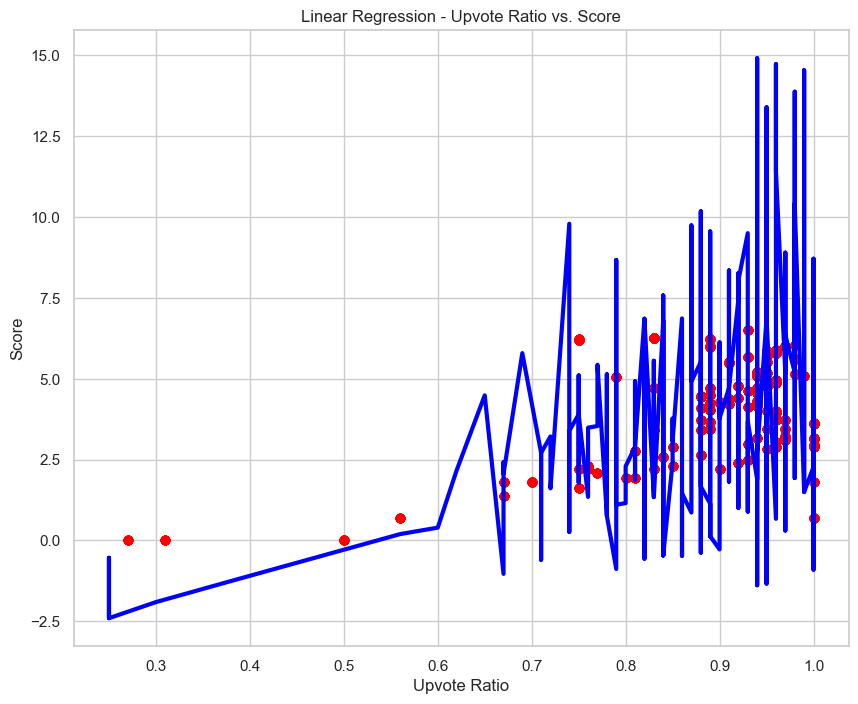

In [141]:
plt.scatter(gpt3_model['X']['upvote_ratio'], gpt3_model['y'], color='red')
plt.plot(gpt3_model['X_test']['upvote_ratio'], gpt3_model['y_pred'], color='blue', linewidth=3)
plt.xlabel('Upvote Ratio')
plt.ylabel('Score')
plt.title('Linear Regression - Upvote Ratio vs. Score')
plt.show()